In [5]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Reading csv and inspecting first 5 rows

df = pd.read_csv('mcdonalds.csv')
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [7]:
# inspecting column names

df.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [8]:
# inspecting the shape of the dataframe

df.shape

(1453, 15)

In [21]:
# checking if the dataset contains any null values

df.isna().sum()

yummy             0
convenient        0
spicy             0
fattening         0
greasy            0
fast              0
cheap             0
tasty             0
expensive         0
healthy           0
disgusting        0
Like              0
Age               0
VisitFrequency    0
Gender            0
dtype: int64

In [24]:
# inspecting the like column

df['Like'].value_counts()

+3              229
+2              187
0               169
+4              160
+1              152
I hate it!-5    152
I love it!+5    143
-3               73
-4               71
-2               59
-1               58
Name: Like, dtype: int64

In [27]:
# inspecting the age column

df['Gender'].value_counts()

Female    788
Male      665
Name: Gender, dtype: int64

In [28]:
# inspecting the visit frequency column

df['VisitFrequency'].value_counts()

Once a month             439
Every three months       342
Once a year              252
Once a week              235
Never                    131
More than once a week     54
Name: VisitFrequency, dtype: int64

In [9]:
# Converting Yes/No to binary values

bin_cols = df.columns[:11]
for col in bin_cols:
    df[col] = df[col].map(lambda x : 1 if x == 'Yes' else 0)

In [11]:
# inspecting after the tranformation from verbal to binary

df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,Female
1,1,1,0,1,1,1,1,1,1,0,0,+2,51,Every three months,Female
2,0,1,1,1,1,1,0,1,1,1,0,+1,62,Every three months,Female
3,1,1,0,1,1,1,1,1,0,0,1,+4,69,Once a week,Female
4,0,1,0,1,1,1,1,0,0,1,0,+2,49,Once a month,Male


In [18]:
# inspecting the average value of each transformed segmentation variable

for col in bin_cols:
    temp = (df[col] == 1).sum()/len(df)
    print(col + ':', round(temp, 2))

yummy: 0.55
convenient: 0.91
spicy: 0.09
fattening: 0.87
greasy: 0.53
fast: 0.9
cheap: 0.6
tasty: 0.64
expensive: 0.36
healthy: 0.2
disgusting: 0.24


In [29]:
# describe the dataframe

df.describe()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Age
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,0.552650,0.907777,0.093599,0.867171,0.526497,0.900206,0.598761,0.644184,0.357880,0.198899,0.242946,44.604955
std,0.497391,0.289440,0.291371,0.339506,0.499469,0.299828,0.490318,0.478925,0.479542,0.399309,0.429010,14.221178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,45.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,71.000000


### EDA

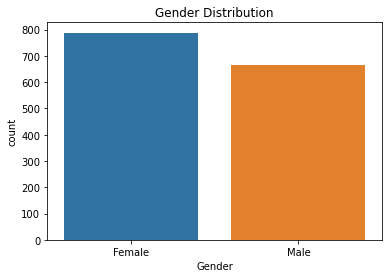

In [50]:
# inspect the distribution of Gender in the dataset

sns.countplot(x = df['Gender'])
plt.title('Gender Distribution')
plt.show()

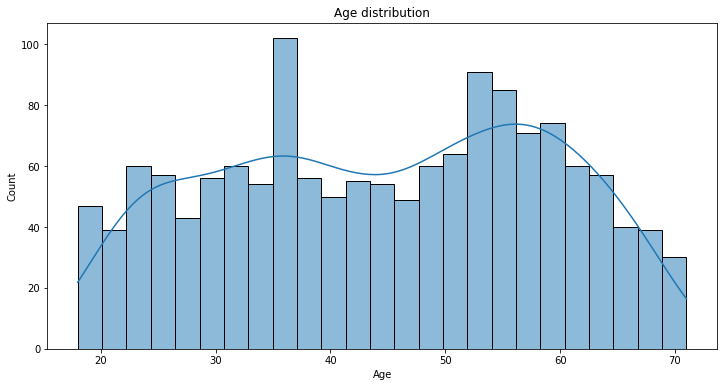

In [63]:
# inspecting the distribution of age 

plt.figure(figsize = (12, 6))
sns.histplot(x = df['Age'], bins = 25, kde = True)
plt.title('Age distribution')
plt.show()

In [53]:
df['Age'].nunique()

54

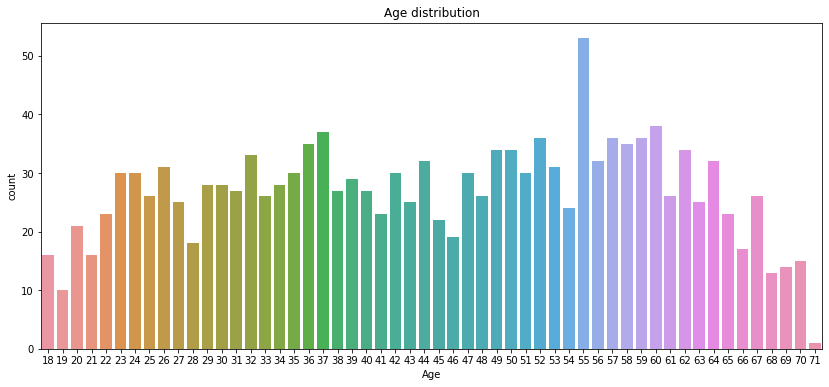

In [55]:
# as in the dataset unqiue ages are only 54 we can also see the count plot

plt.figure(figsize = (14, 6))
sns.countplot(x = df['Age'])
plt.title('Age distribution')
plt.show()

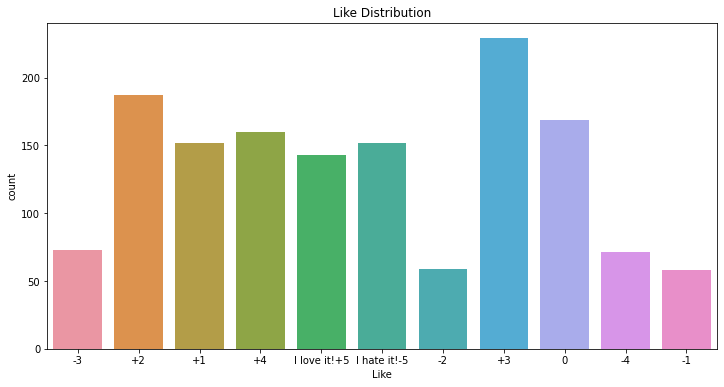

In [64]:
# inspecting the like column

plt.figure(figsize = (12, 6))
sns.countplot(x = df['Like'])
plt.title('Like Distribution')
plt.show()

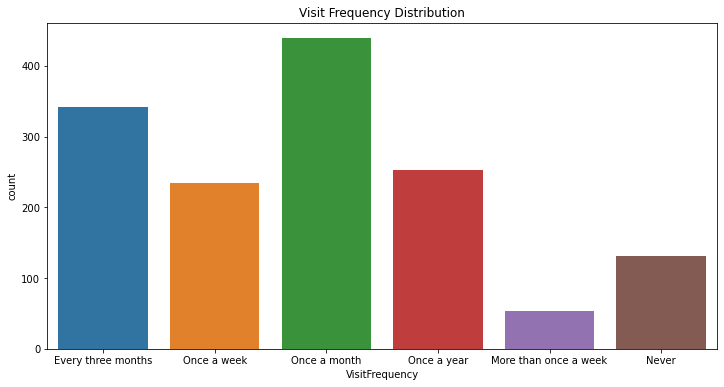

In [66]:
# inspecting visit frequency

plt.figure(figsize = (12, 6))
sns.countplot(x = df['VisitFrequency'])
plt.title('Visit Frequency Distribution')
plt.show()

In [77]:
# now lets plot the average of the segmentation varibales

temp = []
for col in bin_cols:
    temp.append(round((df[col] == 1).sum()/len(df), 2))

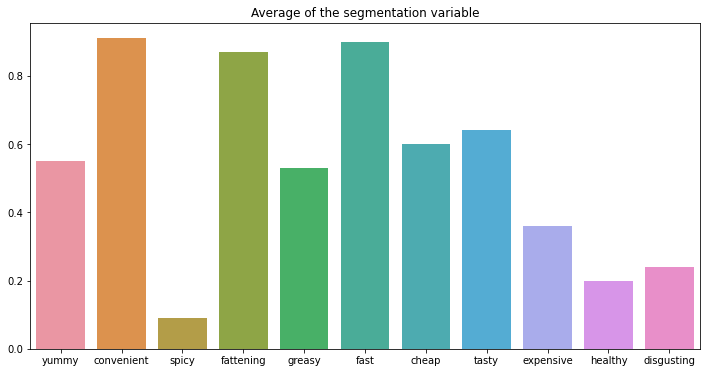

In [81]:
plt.figure(figsize = (12, 6))
sns.barplot(x = bin_cols, y = temp)
plt.title('Average of the segmentation variable')
plt.show()

In [82]:
# transforming like column to numeric

df['Like'] = df['Like'].replace({'I hate it!-5': '-5','I love it!+5':'+5'})
df['Like'] = df['Like'].map(lambda x : int(x))

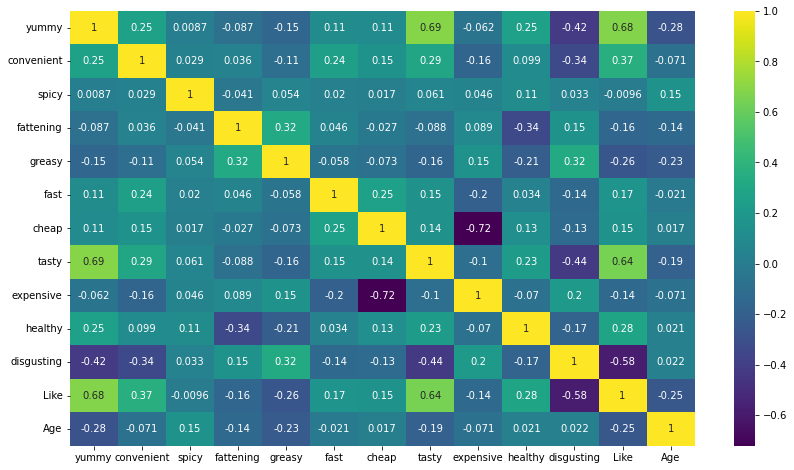

In [92]:
# lets inspect the correlation between variables

plt.figure(figsize = (14, 8))
sns.heatmap(df.corr(), cmap = 'viridis', annot = True)
plt.show()

#### Some insights can be gained from the above heat map

1) Presence of some redundant variables like : **tasty and yummy, cheap and expensive, fattening and healthy**.

2) There is high **positive** correlation between **likeness and yummy, likeness and convenience** which makes sense.

3) There is high **negative** correlation between likeness and disgusting and also some negative correlation with **likeness and greasy, likeness and age** (Higher age people are less probable to like McDonalds).

### PCA

In [93]:
from sklearn.decomposition import PCA

In [104]:
# transforming the data by PCA and viewing it from a diffrent lens

x = df.iloc[:, :11].values

pca = PCA(n_components=11)
pc_x = pca.fit_transform(x)

pc_x

array([[ 0.42536706, -0.21907878,  0.6632553 , ...,  0.18100693,
         0.51570617, -0.56707389],
       [-0.21863768,  0.38818996, -0.73082668, ...,  0.11147641,
         0.49331285, -0.50044033],
       [ 0.37541475,  0.73043507, -0.12203978, ..., -0.32228786,
         0.06175857,  0.24274108],
       ...,
       [-0.18589445,  1.06266156,  0.22085675, ...,  0.03825472,
         0.05651822, -0.01279977],
       [-1.18206441, -0.03856977,  0.56156066, ...,  0.02226748,
        -0.00257265, -0.10531631],
       [ 1.55024186,  0.27503101, -0.01373727, ..., -0.13658866,
        -0.43279782, -0.45607556]])

In [110]:
# converting the pc_x back to dataframe so that we can use pandas tools to visulaize eassily

pc_cols = []
for i in range(1, 12):
    pc_cols.append('PC' + str(i))
    
df_pc = pd.DataFrame(data = pc_x, columns=pc_cols)

In [113]:
# inspecting first 5 rows of the transformed segmentation variables

df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.425367,-0.219079,0.663255,-0.401300,0.201705,-0.389767,-0.211982,0.163235,0.181007,0.515706,-0.567074
1,-0.218638,0.388190,-0.730827,-0.094724,0.044669,-0.086596,-0.095877,-0.034756,0.111476,0.493313,-0.500440
2,0.375415,0.730435,-0.122040,0.692262,0.839643,-0.687406,0.583112,0.364379,-0.322288,0.061759,0.242741
3,-0.172926,-0.352752,-0.843795,0.206998,-0.681415,-0.036133,-0.054284,-0.231477,-0.028003,-0.250678,-0.051034
4,0.187057,-0.807610,0.028537,0.548332,0.854074,-0.097305,-0.457043,0.171758,-0.074409,0.031897,0.082245


In [119]:
# standard devaition of each components can be seen

df_pc.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
count,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03,1.453000e+03
mean,-1.711562e-17,-5.807085e-17,2.750725e-17,2.383961e-17,1.100290e-17,-3.331433e-17,2.964670e-17,-1.222544e-18,-6.418357e-18,4.829050e-17,6.571176e-18
std,7.570495e-01,6.074556e-01,5.046195e-01,3.987986e-01,3.374050e-01,3.102746e-01,2.896973e-01,2.751220e-01,2.652511e-01,2.488418e-01,2.369028e-01
min,-1.188421e+00,-1.040274e+00,-8.808133e-01,-5.906209e-01,-1.045938e+00,-8.524911e-01,-8.059463e-01,-9.316201e-01,-9.557606e-01,-8.871971e-01,-8.851439e-01
25%,-5.476794e-01,-3.568482e-01,-4.507793e-01,-2.814986e-01,-2.433247e-01,-1.927027e-01,-1.342190e-01,-1.717258e-01,-1.181233e-01,-1.465751e-01,-1.053163e-01
50%,-7.074592e-02,-1.151632e-01,2.687734e-02,-1.163200e-01,3.348785e-02,-3.460184e-02,-6.366220e-02,-3.475619e-02,3.868061e-02,3.020635e-02,-1.201409e-02
75%,4.933012e-01,3.915540e-01,3.515939e-01,2.702298e-01,2.048293e-01,1.747453e-01,2.318357e-02,1.295966e-01,7.987794e-02,7.001416e-02,8.554080e-02
max,1.705573e+00,1.279130e+00,1.326976e+00,1.355278e+00,1.053327e+00,1.323793e+00,1.350886e+00,1.121388e+00,1.086693e+00,1.181524e+00,9.255829e-01


In [114]:
# inspecting the propotion of explained variance by each component

pca.explained_variance_

array([0.57312398, 0.36900226, 0.2546408 , 0.15904032, 0.11384214,
       0.09627033, 0.08392454, 0.07569209, 0.07035814, 0.06192225,
       0.05612296])

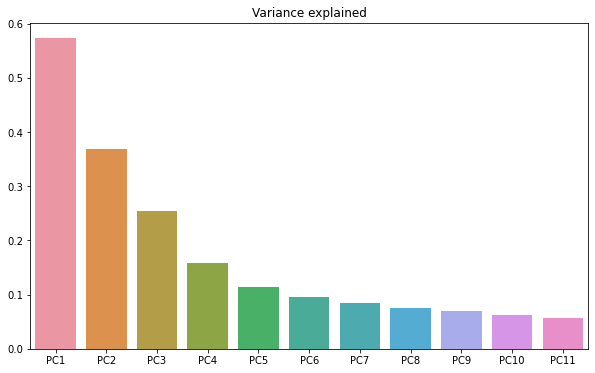

In [117]:
plt.figure(figsize=(10, 6))
sns.barplot(x = df_pc.columns, y = pca.explained_variance_)
plt.title('Variance explained')
plt.show()

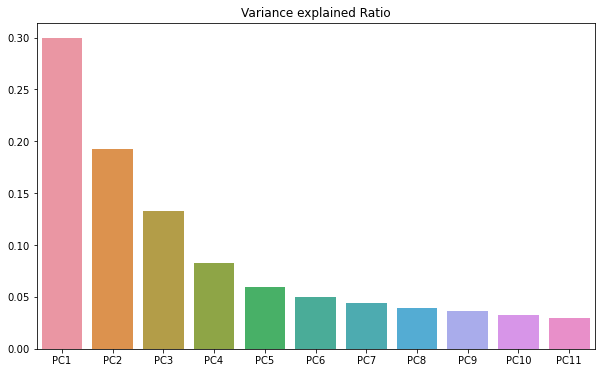

In [118]:
# inspecting the explained variance ratio by each component

plt.figure(figsize=(10, 6))
sns.barplot(x = df_pc.columns, y = pca.explained_variance_ratio_)
plt.title('Variance explained Ratio')
plt.show()

#### As we can see about 50% of the variance is explained just by first two components and about 63% of the variance is explained just by first three component, this signals that we may have redundant variables which we saw in the heatmap of correlation of variables.

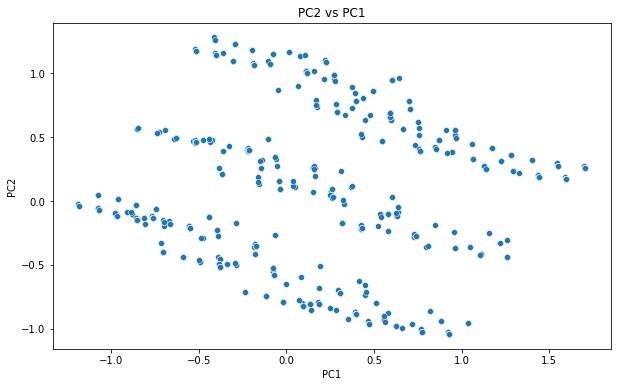

In [123]:
# plotting PCA1 and PCA2

plt.figure(figsize = (10 ,6))
sns.scatterplot(x = df_pc['PC1'],y = df_pc['PC2'])
plt.title('PC2 vs PC1')
plt.show()

In [124]:
# finding loadings

# PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed.

# Loadings Matrix = V * (E)^0.5
# Where V is pca.components_.T and E is np.sqrt(pca.explained_variance_)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [126]:
# inspecting shape of loadings

loadings.shape

(11, 11)

In [133]:
# converting it into df and inspecting

df_loadings = np.round(pd.DataFrame(data = loadings,
                           columns = df_pc.columns,
                          index = bin_cols), 3)

In [134]:
df_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.361,0.221,-0.154,0.022,-0.104,0.053,-0.081,0.004,0.152,-0.027,0.011
convenient,-0.118,0.010,-0.032,-0.057,0.094,-0.108,-0.017,-0.031,-0.005,-0.166,-0.128
spicy,-0.005,0.011,-0.019,0.079,0.024,-0.110,0.205,0.103,0.106,-0.019,0.034
fattening,0.088,-0.021,-0.163,-0.141,-0.025,-0.126,-0.112,0.162,-0.043,-0.001,0.059
greasy,0.230,-0.039,-0.405,0.101,0.122,0.065,0.010,-0.038,-0.001,0.002,0.000
fast,-0.082,-0.053,-0.033,-0.039,0.036,-0.184,-0.025,-0.173,0.044,0.060,0.080
cheap,-0.255,-0.371,-0.075,0.047,-0.044,-0.032,-0.012,0.039,0.020,0.107,-0.116
tasty,-0.357,0.187,-0.145,-0.001,-0.071,-0.024,0.104,-0.020,-0.170,0.020,0.005
expensive,0.249,0.365,0.012,0.027,-0.001,-0.081,-0.020,0.008,0.018,0.113,-0.116
healthy,-0.162,0.047,0.097,0.304,0.097,-0.055,-0.101,0.049,-0.049,-0.009,0.037


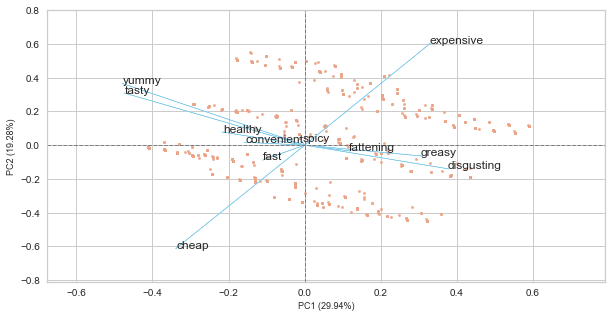

In [155]:
from bioinfokit.visuz import cluster

# plotiing the 2D biplot

cluster.biplot(cscore=df_pc.values, loadings=pca.components_, labels=df.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2),
    var2=round(pca.explained_variance_ratio_[1]*100, 2),show=True,dim=(10,5))

### Extracting Segements

Using Kmeans clustering

In [169]:
# using Kmeans clustering

from sklearn.cluster import KMeans

# we will try for many values of k from 2 to 8
cluster_interia = []
n_clusters = []

for k in range(1, 9):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x)
    cluster_interia.append(kmeans.inertia_)
    n_clusters.append(k)

C:\Users\akshay\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  "KMeans is known to have a memory leak on Windows "


Text(0.5, 1.0, 'Kmeans')

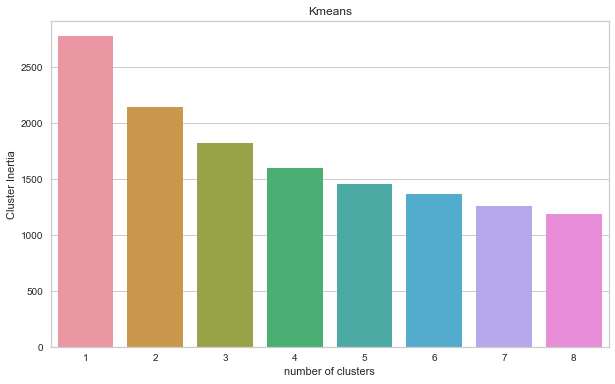

In [170]:
# Now we plot the inertia for every cluster 

plt.figure(figsize = (10, 6))
sns.barplot(x = n_clusters, y = cluster_interia)
plt.xlabel('number of clusters')
plt.ylabel('Cluster Inertia')
plt.title('Kmeans')

In [171]:
# from above plot we can make a choice that we can divide our market into 4 segments.

# Also two way clustering can be used if the inertia falloff is not that significant.

# The way we do two way clustering is described below
# we initialize a high k and perform k means than the reperesentative of each cluster is fed to hierarchy clustering 
# in which we can see the number of segments more clearly. This is done because hierarchical clustering is expensive 
# for large datasets so we reduce all data points by their reperesentatives.

In [172]:
# using 4 segments

kmeans = KMeans(n_clusters = 4)
kmeans.fit(x)

KMeans(n_clusters=4)

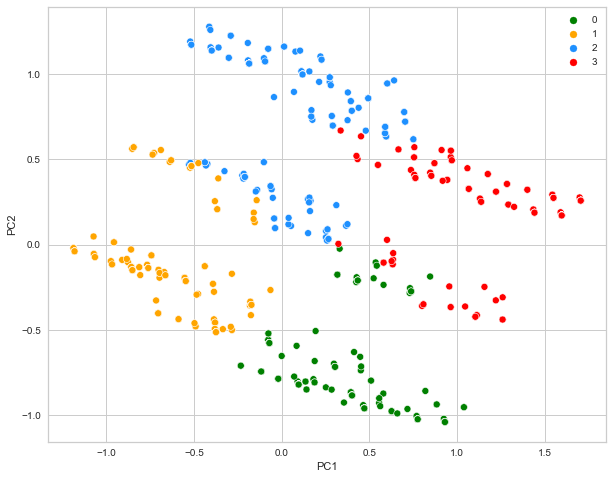

In [259]:
# visualizing the clusters

pred = kmeans.predict(x)

plt.figure(figsize = (10, 8))

sns.scatterplot(x = df_pc['PC1'], y = df_pc['PC2'], hue = pred,
                palette=['green','orange','dodgerblue','red'])

plt.show()

**Using Hierarchical Clustering**

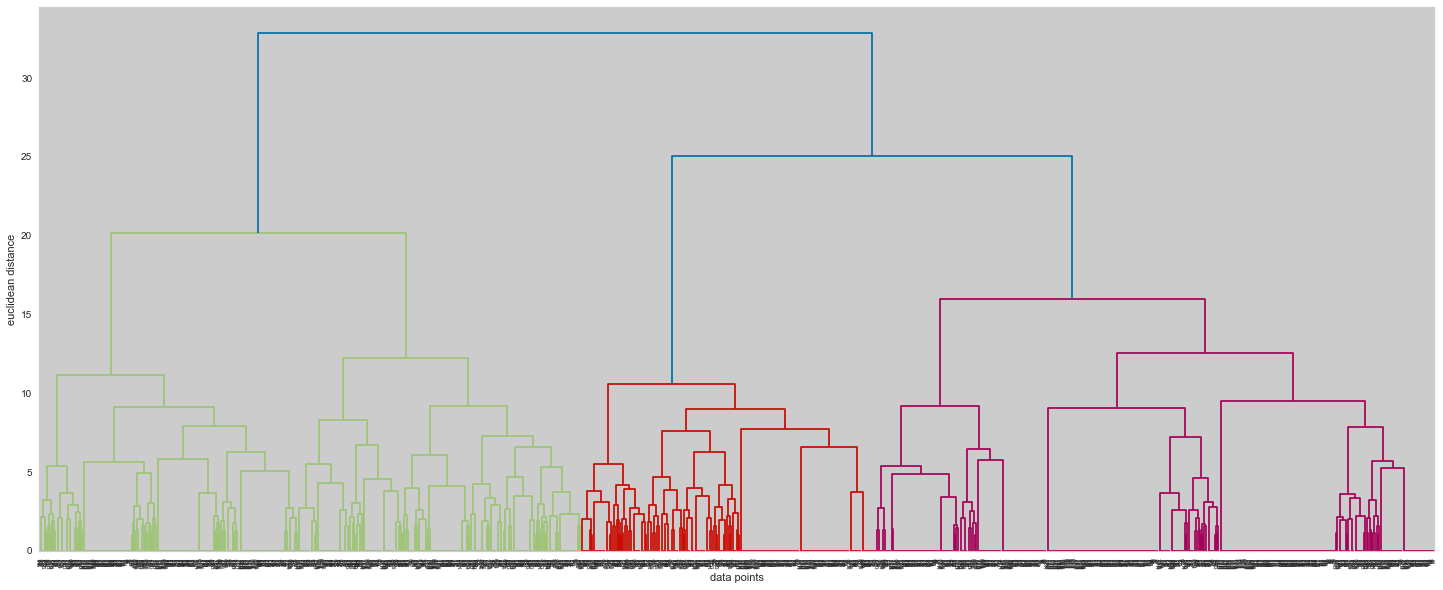

In [208]:
# using Hierarchical Clustering

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

merg = linkage(x, method="ward")
plt.figure(figsize=(25,10))
dendrogram(merg,leaf_rotation = 90)
plt.xlabel("data points")
plt.ylabel("euclidean distance")
plt.show()

In [209]:
# the above figure sugggests we can have 3 segments (long 3 vertcal lines)

agglo_clustering = AgglomerativeClustering(n_clusters = 3, affinity= "euclidean", linkage = "ward")
agglo_cluster_pred = agglo_clustering.fit_predict(x)

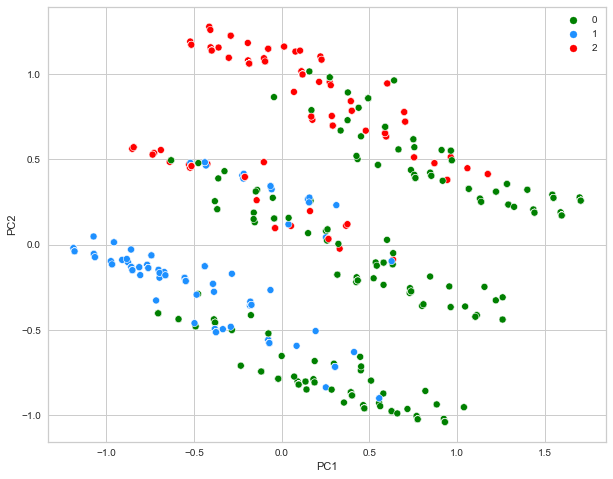

In [211]:
# visualizing the Agglomerative clustering

# visualizing the clusters

plt.figure(figsize = (10, 8))

sns.scatterplot(x = df_pc['PC1'], y = df_pc['PC2'], hue = agglo_cluster_pred,
                palette=['green', 'dodgerblue','red'])

plt.show()

### Describing Segements

In [260]:
df['cluster'] = pred

In [261]:
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender,cluster
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,Female,0
1,1,1,0,1,1,1,1,1,1,0,0,2,51,Every three months,Female,2
2,0,1,1,1,1,1,0,1,1,1,0,1,62,Every three months,Female,2
3,1,1,0,1,1,1,1,1,0,0,1,4,69,Once a week,Female,1
4,0,1,0,1,1,1,1,0,0,1,0,2,49,Once a month,Male,0


In [281]:
df['cluster'].value_counts()

1    570
2    334
0    309
3    240
Name: cluster, dtype: int64

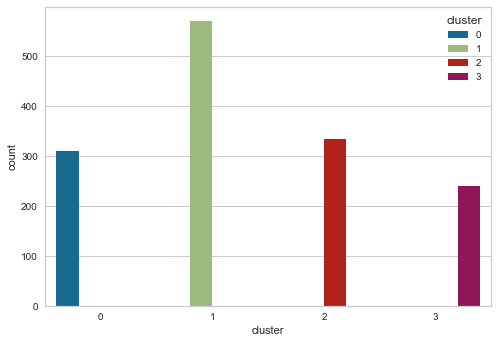

In [283]:
sns.countplot(x = df['cluster'], hue = df['cluster'])
plt.show()

In [278]:
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

crosstable = pd.crosstab(df['cluster'], df['Gender'])
crosstable

Gender,Female,Male
cluster,,
0,183,126
1,343,227
2,161,173
3,101,139


<Figure size 1008x720 with 0 Axes>

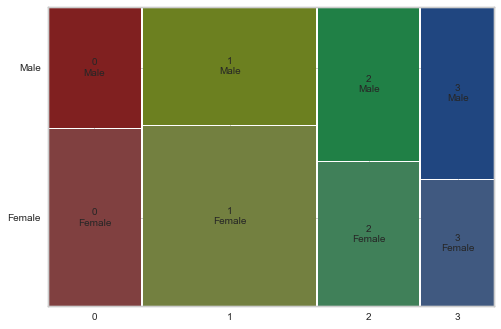

In [263]:
plt.figure(figsize = (14, 10))
mosaic(crosstable.stack())
plt.show()

In [264]:
crosstable = pd.crosstab(df['cluster'], df['Like'])
crosstable

Like,-5,-4,-3,-2,-1,0,1,2,3,4,5
cluster,,,,,,,,,,,
0,54,36,34,29,26,53,32,31,12,2,0
1,4,4,2,6,12,42,63,87,140,111,99
2,5,4,7,6,8,37,44,63,69,47,44
3,89,27,30,18,12,37,13,6,8,0,0


<Figure size 1008x720 with 0 Axes>

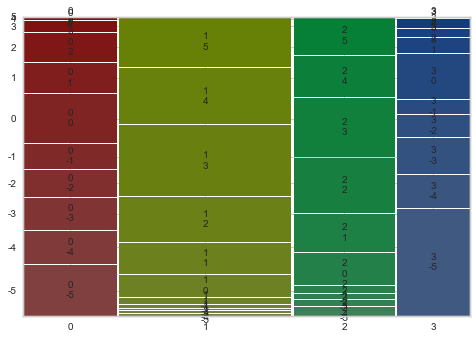

In [265]:
plt.figure(figsize = (14, 10))
mosaic(crosstable.stack())
plt.show()

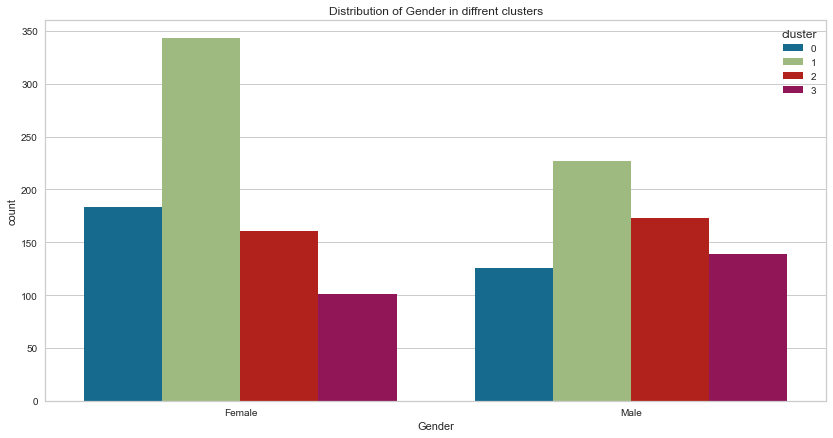

In [266]:
plt.figure(figsize = (14, 7))
sns.countplot(x = df['Gender'], hue = df['cluster'])
plt.title('Distribution of Gender in diffrent clusters')
plt.show()

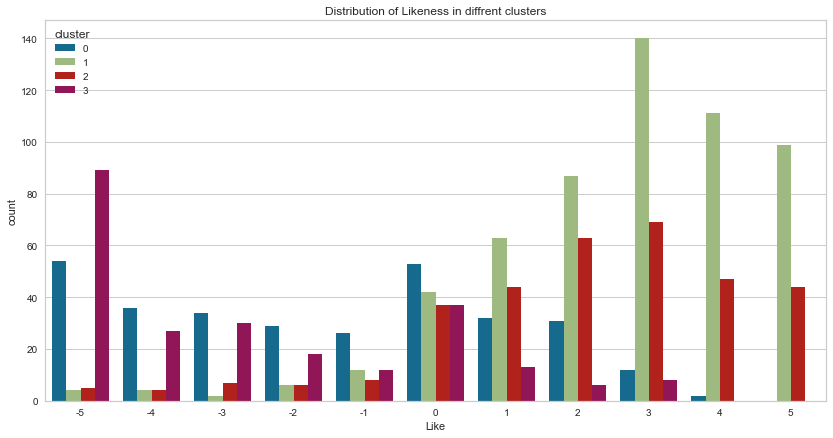

In [267]:
plt.figure(figsize = (14, 7))
sns.countplot(x = df['Like'], hue = df['cluster'])
plt.title('Distribution of Likeness in diffrent clusters')
plt.show()

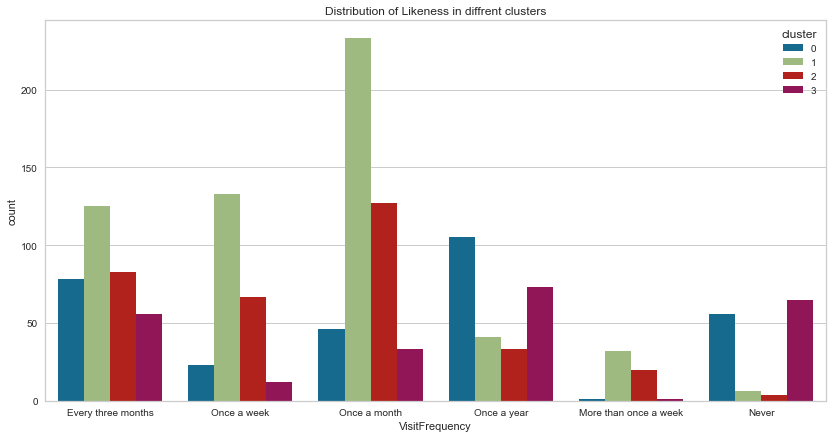

In [268]:
plt.figure(figsize = (14, 7))
sns.countplot(x = df['VisitFrequency'], hue = df['cluster'])
plt.title('Distribution of Likeness in diffrent clusters')
plt.show()

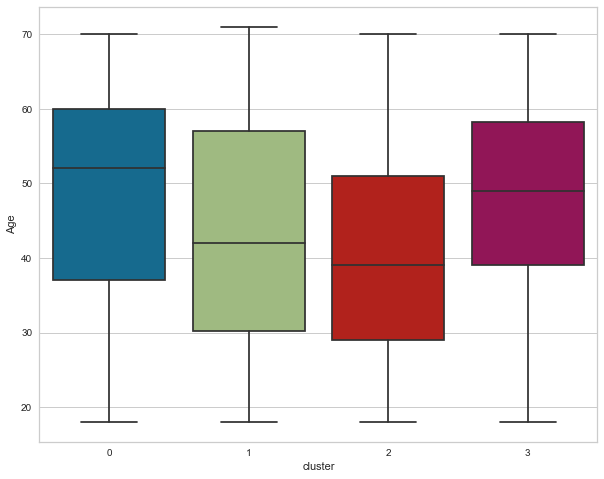

In [275]:
plt.figure(figsize = (10, 8))
sns.boxplot(x="cluster", y="Age", data=df)
plt.show()

### Selecting the target

In [285]:
# we need to give numerical encodings to visitFrequency column
# we will provide meaningful encoding to the columns (more value means more visit)


df['VisitFrequency'].unique()

array(['Every three months', 'Once a week', 'Once a month', 'Once a year',
       'More than once a week', 'Never'], dtype=object)

In [289]:
df['frequency'] = df['VisitFrequency'].replace({
    'Never':0,
    'Once a week':4,
    'More than once a week':5,
    'Once a month' : 3,
    'Every three months': 2,
     'Once a year': 1
})

In [291]:
df.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender,cluster,frequency
0,0,1,0,1,0,1,1,0,1,0,0,-3,61,Every three months,Female,0,2
1,1,1,0,1,1,1,1,1,1,0,0,2,51,Every three months,Female,2,2
2,0,1,1,1,1,1,0,1,1,1,0,1,62,Every three months,Female,2,2
3,1,1,0,1,1,1,1,1,0,0,1,4,69,Once a week,Female,1,4
4,0,1,0,1,1,1,1,0,0,1,0,2,49,Once a month,Male,0,3


In [313]:
# describing each cluster

like_by_cluster = []
visit_by_cluster = []
female_by_cluster = []

for i in range(4):
    like_by_cluster.append(df[df['cluster'] == i]['Like'].mean())
    visit_by_cluster.append(df[df['cluster'] == i]['frequency'].mean())
    female_by_cluster.append(len(df[((df['cluster'] == i) & (df['Gender'] == 'Female'))]))
    

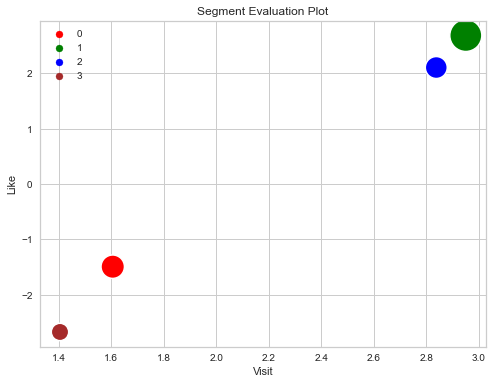

In [341]:
# The segment evaluation plot  is extremely simplified because only
# a small number of descriptor variables are available for the fast food data set. In
# the plot the frequency of visiting McDonald’s is plotted along the x-axis. The
# extent of liking or hating McDonald’s is plotted along the y-axis. The bubble size
# represents the percentage of female consumers

plt.figure(figsize = (8, 6))
sns.scatterplot(x = visit_by_cluster, y = like_by_cluster, hue = [0,1,2,3], s = np.array(female_by_cluster)*3, 
               palette=['Red', 'Green', 'Blue', 'Brown'])

plt.xlabel('Visit')
plt.ylabel('Like')
plt.title('Segment Evaluation Plot')
plt.show()